<a href="https://colab.research.google.com/github/RyanTahnikoyev/contryrisk-clustering/blob/main/countryrisk_clustering_notebook_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install kneed

In [ ]:
# loading packages

import os

import pandas as pd
import numpy as np

# plotting packages
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px

# Kmeans algorithm from scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from kneed import KneeLocator
import argparse
import json
import re
import os
import sys


# Importing Raw Data (Task-a)

In [ ]:
# load raw data
DATA_FOLDER = './'
# raw = pd.read_csv(os.path.join(DATA_FOLDER, 'country risk 2019 data.csv'))

raw = pd.read_csv("/content/drive/MyDrive/Country Risk 2019 Data.csv")
# check the raw data
print("Size of the dataset (row, col): ", raw.shape)
print("\nFirst 5 rows\n", raw.head(n=5))

Size of the dataset (row, col):  (121, 6)

First 5 rows
      Country Abbrev  Corruption  Peace  Legal  GDP Growth
0    Albania     AL          35  1.821  4.546       2.983
1    Algeria     DZ          35  2.219  4.435       2.553
2  Argentina     AR          45  1.989  5.087      -3.061
3    Armenia     AM          42  2.294  4.812       6.000
4  Australia     AU          77  1.419  8.363       1.713


# Exploratory Data Analysis


### Feature Exploration
Observing the feature values in the following representation,

In [ ]:
fig1 = px.scatter(raw, x="Corruption", y="Legal", color="GDP Growth",
                 size="Peace")
fig1.update_layout(title="All 4 Features Representation")
fig1.show()

Let's have a look at the entire dataset(excluding Country and Abbreviation)

In [ ]:
fig = px.scatter_matrix(raw.drop(["Abbrev","Country"],axis=1),
width=600, height=800)
fig.show()

## Summary Statistics

**Note that all features have quite different variances.**

In [ ]:
# print summary statistics
print("\nSummary statistics\n", raw.describe())


Summary statistics
        Corruption       Peace       Legal  GDP Growth
count  121.000000  121.000000  121.000000  121.000000
mean    46.842975    2.001017    5.752529    2.657529
std     18.702499    0.461485    1.373932    2.563741
min     15.000000    1.072000    2.671000   -9.459000
25%     33.000000    1.699000    4.785000    1.249000
50%     41.000000    1.939000    5.455000    2.600000
75%     60.000000    2.294000    6.488000    4.000000
max     87.000000    3.369000    8.712000    7.800000


## Observing Correlations between the features
Observing and plotting correlations between the features,

In [ ]:
sns.set(style="whitegrid", color_codes=True)
sns.set(rc = {'figure.figsize':(12,6)})

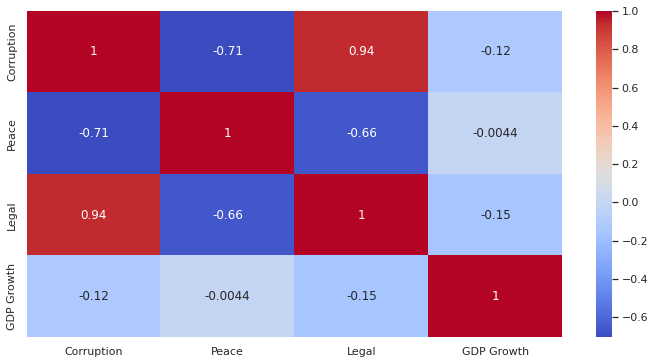

In [ ]:
correlation = raw.corr()
sns.heatmap(correlation, cmap="coolwarm", annot=True)

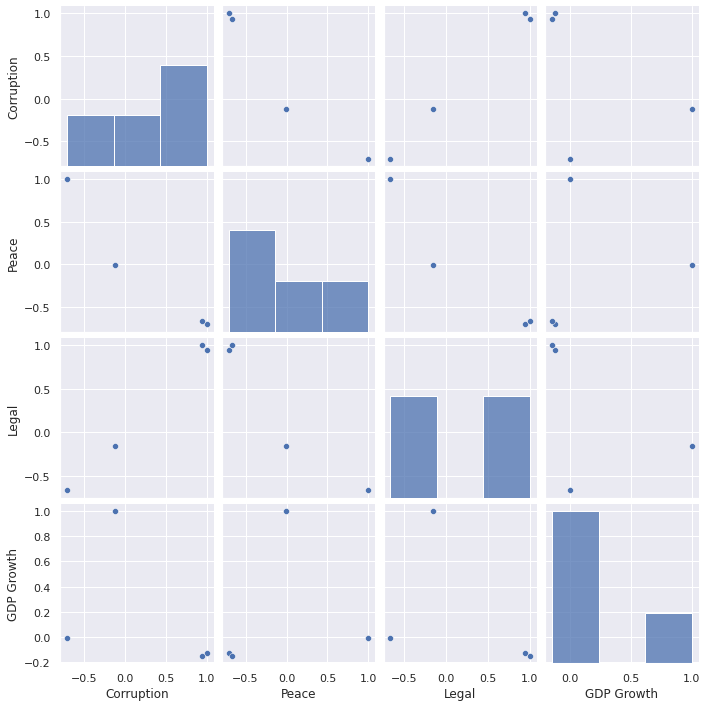

In [ ]:
sns.set(rc = {'figure.figsize':(6,2)})
sns.pairplot(raw.corr())
# sns.pairplot(raw.corr(), kind="reg", hue="Corruption", markers=["o", "s", "D"]) #with best-fit line

In [ ]:
# sns.lmplot(x="GDP Growth", y="Peace", hue="Country", data = raw, \
#               palette="Set2", markers=["o", "s", "D"])

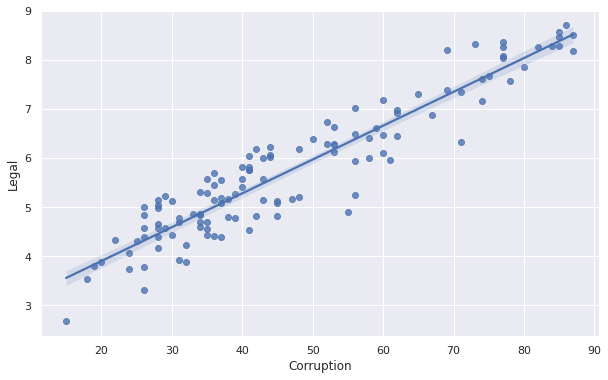

In [ ]:
# sns.scatterplot(raw.Corruption, raw.Legal)
sns.set(rc = {'figure.figsize':(10,6)})
sns.regplot(x="Corruption", y="Legal", data=raw)

It seems that the features named Corruption and Legal has high correlation value. Feature "Corruption" and feature "Legal" has correlation efficient value(R) of 0.94 which implies the relation between legal structure of a country and its impact on the overall system of it. Having functioning legal system and law enforcement entities ensures the sustainability, credibility and overall development of a country which can be implied through the numbers of GDP Growth.

Now, let's have a look at the frequencies of the respective features.

## Observing Frequencies of the features

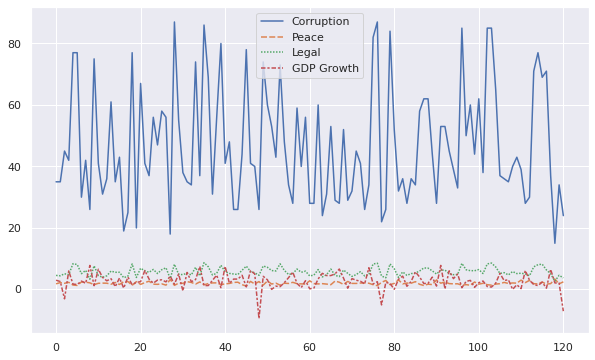

In [ ]:
p = sns.lineplot(data = raw)

## Distribution of the features

<Figure size 360x144 with 0 Axes>

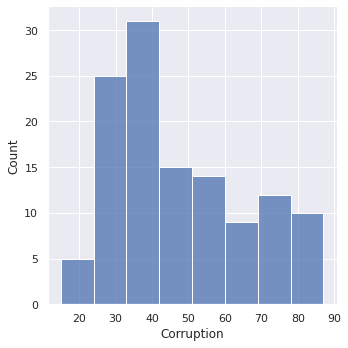

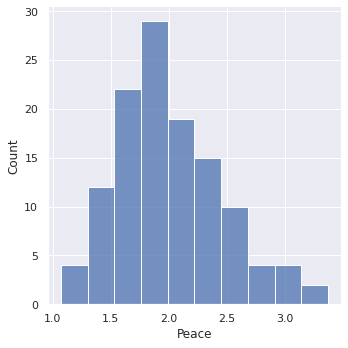

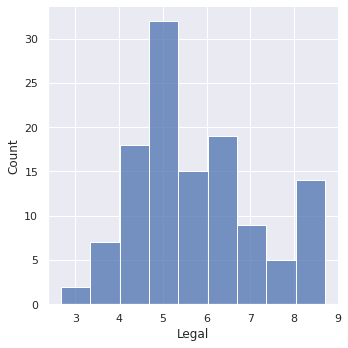

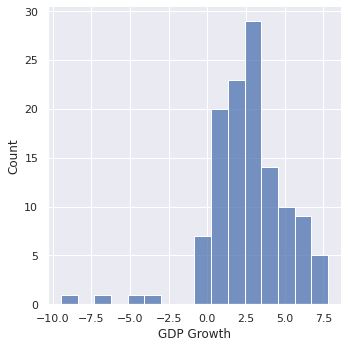

In [ ]:
sns.set(rc = {'figure.figsize':(5,2)})
plt.figure(1)
sns.displot(raw['Corruption']);

plt.figure(2)
sns.displot(raw['Peace']);

plt.figure(3)
sns.displot(raw['Legal']);

plt.figure(4)
sns.displot(raw['GDP Growth']);


**Note that distributions for GDP Growth is quite skewed.**



# Clustering

## Performing clustering with K-Means Clustering Algorithm

In [ ]:
raw.columns

Index(['Country', 'Abbrev', 'Corruption', 'Peace', 'Legal', 'GDP Growth'], dtype='object')

In [ ]:
X = raw[['Peace', 'Corruption', 'Legal', 'GDP Growth',]]
print(X.head(5))

   Peace  Corruption  Legal  GDP Growth
0  1.821          35  4.546       2.983
1  2.219          35  4.435       2.553
2  1.989          45  5.087      -3.061
3  2.294          42  4.812       6.000
4  1.419          77  8.363       1.713


### K-Means without Normalization

A fundamental step for K-Means Clustering algorithm is to determine the optimal number of clusters into which the data may be clustered. Here in this notebook, The Elbow Method is used to determine this optimal value of k.

To perform the elbow method, run several k-means, increment k with each iteration, and record the SSE:

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

Plotting the SSE list,

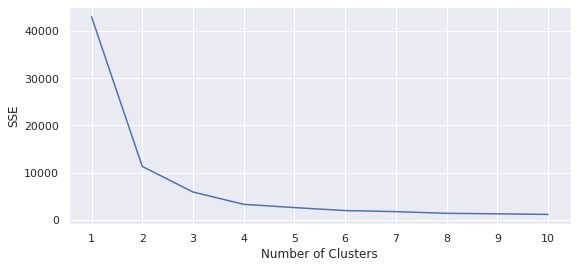

In [ ]:
#  plt.style.use("fivethirtyeight")
sns.set(rc = {'figure.figsize':(9,4)})
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#### Identifying the elbow point

In [ ]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

print("The elbow point for the given dataset is:", kl.elbow)

The elbow point for the given dataset is: 3


#### Instantiating the model

In [ ]:
cluster_number = kl.elbow
kmeans = KMeans(n_clusters=cluster_number)  #Seleting the hyper-parameters
labels = kmeans.fit_predict(X)
raw_copy = raw.copy()

In [ ]:
raw_copy['Cluster'] = labels
raw_copy.head()

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth,Cluster
0,Albania,AL,35,1.821,4.546,2.983,1
1,Algeria,DZ,35,2.219,4.435,2.553,1
2,Argentina,AR,45,1.989,5.087,-3.061,0
3,Armenia,AM,42,2.294,4.812,6.000,1
4,Australia,AU,77,1.419,8.363,1.713,2


#### Visualizing the clusters



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



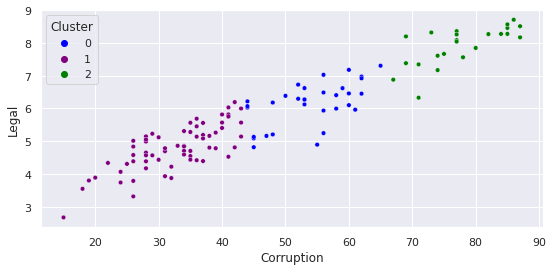

In [ ]:
sns.scatterplot(raw_copy.Corruption, raw_copy.Legal, hue=raw_copy.Cluster, palette=['blue', 'purple', 'green'], alpha=1, s=21)

### K-Means with Normalization

#### Feature Scaling

The values for all features in the dataset must be transformed to the same scale. Features like **"GDP Growth"** need to go through the process of tranforming its contents or numerical features to use the same scale.
 

In [ ]:
# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Experiment: Tuning "n_init" Hyperparameter (Task-b)

The KMeans estimator class in scikit-learn is where the algorithm parameters need to be set before fitting the estimator to the data. 
The parameters used in this notebook,

**init:** controls the initialization technique. The standard version of the k-means algorithm is implemented by setting init to "random". .

**n_clusters:** sets k for the clustering step. 

**n_init:** sets the number of initializations to perform. The default behavior for the scikit-learn algorithm is to perform ten k-means runs and return the results of the one with the lowest SSE.

**max_iter:** sets the number of maximum iterations for each initialization of the k-means algorithm.

Now, let's randomly change the value of "n_init" hyperparameter to observe the changes in the cluster formations. 

In [ ]:
random_n_init_values = [2,10,50,70,100]
predicted_clusters_list = []

for n_init_value in random_n_init_values:
    # K-Means estimator class Hyperparameters
    kmeans_kwargs = {
    "init": "random",
    "n_init": n_init_value,
    "max_iter": 300,
    "random_state": 1,
}
    # Identified elbow point value is assigned as the n_clusters
    kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
    y_predict = kmeans.fit_predict(X_scaled)
    print("FOR n_init value:",n_init_value)
    print("Predicted cluster label:",y_predict)
    print("\n")
    predicted_clusters_list.append(y_predict)
    

FOR n_init value: 2
Predicted cluster label: [1 1 0 1 2 2 0 0 1 2 1 1 1 2 0 1 0 1 2 0 2 1 0 2 1 2 2 0 2 1 0 1 0 2 1 2 2
 1 1 2 1 1 1 1 1 2 1 1 0 2 0 2 0 2 1 1 1 2 0 2 0 0 2 1 1 2 1 1 2 0 1 1 1 0
 1 2 2 0 0 2 2 0 1 0 1 1 2 2 2 1 0 1 0 1 1 1 2 2 2 0 2 1 2 2 2 1 1 1 0 0 0
 1 0 2 2 2 2 1 0 1 0]


FOR n_init value: 10
Predicted cluster label: [0 0 2 0 1 1 0 0 0 1 0 0 0 1 2 0 2 0 1 2 1 0 0 1 0 1 1 2 1 0 2 0 0 1 0 1 1
 0 0 1 0 0 0 0 0 1 0 0 2 1 0 1 0 1 0 0 0 1 0 1 2 2 1 0 0 1 0 0 1 2 0 0 0 0
 0 1 1 2 2 1 1 2 0 2 0 0 1 1 1 0 2 0 2 0 0 0 1 1 1 2 1 0 1 1 1 0 0 0 2 0 2
 0 2 1 1 1 1 0 2 0 2]


FOR n_init value: 50
Predicted cluster label: [0 0 2 0 1 1 0 0 0 1 0 0 0 1 2 0 2 0 1 2 1 0 0 1 0 1 1 2 1 0 2 0 0 1 0 1 1
 0 0 1 0 0 0 0 0 1 0 0 2 1 0 1 0 1 0 0 0 1 0 1 2 2 1 0 0 1 0 0 1 2 0 0 0 0
 0 1 1 2 2 1 1 2 0 2 0 0 1 1 1 0 2 0 2 0 0 0 1 1 1 2 1 0 1 1 1 0 0 0 2 0 2
 0 2 1 1 1 1 0 2 0 2]


FOR n_init value: 70
Predicted cluster label: [0 0 2 0 1 1 0 0 0 1 0 0 0 1 2 0 2 0 1 2 1 0 0 1 0 1 1 2 1 0 2 0 0 1 0

#### n_init Hyperparameter with random values

Now, let's observe the clusters created with random n_init hyperparameter values. The clusters with different hyperparameter values are plotted below,


In [ ]:
raw_copy = raw_copy.drop(["Cluster"],axis=1)
raw_copy['Cluster'] = predicted_clusters_list[0]
fig2 = px.scatter_3d(raw_copy, x="Corruption", y="Legal", z="GDP Growth", color="Cluster",
                 size="Peace")
fig2.update_layout(title="High Risk Cluster with n_init Hyperparameter Value = 2")
fig2.show()

In [ ]:
raw_copy = raw_copy.drop(["Cluster"],axis=1)
raw_copy['Cluster'] = predicted_clusters_list[2]
fig2 = px.scatter_3d(raw_copy, x="Corruption", y="Legal", z="GDP Growth", color="Cluster",
                 size="Peace")
fig2.update_layout(title="High Risk Cluster with n_init Hyperparameter Value = 50")
fig2.show()

K-Means Classifier has by default value=10 for "n_init" hyperparameter. Let's observe the cluster shapes and sizes in the Classifier and compare it with the cluster shapes with random n_init values which are generated in the previous sub-section.

In [ ]:
clusters_with_default_n_init_value = predicted_clusters_list[1]
clusters_with_default_n_init_value

array([0, 0, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 2, 0, 1, 2, 1, 0,
       0, 1, 0, 1, 1, 2, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 2, 2, 1, 0, 0, 1,
       0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 2, 0, 2, 0, 0, 1, 1,
       1, 0, 2, 0, 2, 0, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0,
       2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2], dtype=int32)

In [ ]:
raw_copy = raw_copy.drop(["Cluster"],axis=1)
raw_copy['Cluster'] = clusters_with_default_n_init_value
raw_copy.head()

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth,Cluster
0,Albania,AL,35,1.821,4.546,2.983,0
1,Algeria,DZ,35,2.219,4.435,2.553,0
2,Argentina,AR,45,1.989,5.087,-3.061,2
3,Armenia,AM,42,2.294,4.812,6.000,0
4,Australia,AU,77,1.419,8.363,1.713,1


In [ ]:
# Visualize cluster shapes in 3d.

cluster1=raw_copy.loc[raw_copy['Cluster'] == 0]
cluster2=raw_copy.loc[raw_copy['Cluster'] == 1]
cluster3=raw_copy.loc[raw_copy['Cluster'] == 2]

scatter1 = dict(
    mode = "markers",
    name = "Cluster 1",
    type = "scatter3d",    
    x = cluster1.to_numpy()[:,0], y = cluster1.to_numpy()[:,1], z = cluster1.to_numpy()[:,2],
    marker = dict( size=2, color='green')
)
scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2.to_numpy()[:,0], y = cluster2.to_numpy()[:,1], z = cluster2.to_numpy()[:,2],
    marker = dict( size=2, color='blue')
)
scatter3 = dict(
    mode = "markers",
    name = "Cluster 3",
    type = "scatter3d",    
    x = cluster3.to_numpy()[:,0], y = cluster3.to_numpy()[:,1], z = cluster3.to_numpy()[:,2],
    marker = dict( size=2, color='red')
)
cluster1 = dict(
    alphahull = 5,
    name = "Cluster 1",
    opacity = .1,
    type = "mesh3d",    
    x = cluster1.to_numpy()[:,0], y = cluster1.to_numpy()[:,1], z = cluster1.to_numpy()[:,2],
    color='green', showscale = True
)
cluster2 = dict(
    alphahull = 5,
    name = "Cluster 2",
    opacity = .1,
    type = "mesh3d",    
    x = cluster2.to_numpy()[:,0], y = cluster2.to_numpy()[:,1], z = cluster2.to_numpy()[:,2],
    color='red', showscale = True
)
cluster3 = dict(
    alphahull = 5,
    name = "Cluster 3",
    opacity = .1,
    type = "mesh3d",    
    x = cluster3.to_numpy()[:,0], y = cluster3.to_numpy()[:,1], z = cluster3.to_numpy()[:,2],
    color='blue', showscale = True
)
layout = dict(
    title = 'Interactive Cluster Shapes of Country Risk 2019 Data (Turn left/right to observe)',
    scene = dict(
        xaxis = dict( zeroline=True ),
        yaxis = dict( zeroline=True ),
        zaxis = dict( zeroline=True ),
    )
)
fig = dict( data=[scatter1, scatter2, scatter3, cluster1, cluster2, cluster3], layout=layout )
# Use py.iplot() for IPython notebook
plotly.offline.iplot(fig, filename='countryrisk_defaultinit')

The countries plotted with red points belong to the high risk clusters. The countries have comparatively low index values in almost all the features. Some contry has higher GDP values but has high corruption indexes.

Let's see the countries which fall under the high risk cluster,

In [ ]:
cluster2 = raw_copy[raw_copy['Cluster'] == 0]
fig2 = px.scatter_3d(cluster2, x="Corruption", y="Legal", z="GDP Growth", color="Cluster",
                 size="Peace")
fig2.update_layout(title="High Risk Cluster with Default n_init Hyperparameter")
fig2.show()

It is clearly visible that the cluster shapes change with the **n_init** value and the entities in the **"Country"** feature at high risk cluster formation also change with the cluster formations. 

The countries which are not doing well in terms of buidling sustainable legal and law enforcement systems, are facing increase in corruption and decrease in peace index. Most of the under-developed or developing countries are suffering with this problem.

### Experiment: Comparing k-means with 4 features with k-means with 3 features

K-means clustering with 4 features is observed in section named "Experiment: Tuning_n_init" Hyperparameter which is done with the instructions given in task B. 

The following clustering is done with the following hyperparameter values,

*   ***3 Features*** = [Legal, GDP Growth, Peace]
*   ***n_clusters*** = 3 
*   ***n_init*** = 10
*   ***random_state*** = 1



In [ ]:
#Selecting the features
X = raw[['Peace', 'Legal', 'GDP Growth',]]

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means estimator class Hyperparameters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 1,
}

# Instatiationg the model
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
y_predict = kmeans.fit_predict(X_scaled) 

In [ ]:
y_predict

array([2, 2, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 2, 1, 0, 1, 2,
       2, 1, 2, 1, 1, 0, 1, 2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2,
       1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 0, 1, 2, 2, 1,
       2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 1, 0, 0, 1, 1, 0, 2, 0, 2, 2, 1, 1,
       1, 1, 0, 2, 0, 2, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 2,
       0, 2, 0, 1, 1, 1, 1, 2, 0, 2, 0], dtype=int32)

In [ ]:
raw_copy = raw_copy.drop(["Cluster"],axis=1)
raw_copy['Cluster'] = y_predict
figure = px.scatter(raw_copy, x="GDP Growth", y="Legal", color="Cluster",
                 size="Peace")
figure.update_layout(title="High Risk Cluster with 3 Features")
figure.show()

In [ ]:
# Visualize cluster shapes in 3d.

cluster1=raw_copy.loc[raw_copy['Cluster'] == 0]
cluster2=raw_copy.loc[raw_copy['Cluster'] == 1]
cluster3=raw_copy.loc[raw_copy['Cluster'] == 2]

scatter1 = dict(
    mode = "markers",
    name = "Cluster 1",
    type = "scatter3d",    
    x = cluster1.to_numpy()[:,0], y = cluster1.to_numpy()[:,1], z = cluster1.to_numpy()[:,2],
    marker = dict( size=2, color='green')
)
scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2.to_numpy()[:,0], y = cluster2.to_numpy()[:,1], z = cluster2.to_numpy()[:,2],
    marker = dict( size=2, color='blue')
)
scatter3 = dict(
    mode = "markers",
    name = "Cluster 3",
    type = "scatter3d",    
    x = cluster3.to_numpy()[:,0], y = cluster3.to_numpy()[:,1], z = cluster3.to_numpy()[:,2],
    marker = dict( size=2, color='red')
)
cluster1 = dict(
    alphahull = 5,
    name = "Cluster 1",
    opacity = .1,
    type = "mesh3d",    
    x = cluster1.to_numpy()[:,0], y = cluster1.to_numpy()[:,1], z = cluster1.to_numpy()[:,2],
    color='green', showscale = True
)
cluster2 = dict(
    alphahull = 5,
    name = "Cluster 2",
    opacity = .1,
    type = "mesh3d",    
    x = cluster2.to_numpy()[:,0], y = cluster2.to_numpy()[:,1], z = cluster2.to_numpy()[:,2],
    color='red', showscale = True
)
cluster3 = dict(
    alphahull = 5,
    name = "Cluster 3",
    opacity = .1,
    type = "mesh3d",    
    x = cluster3.to_numpy()[:,0], y = cluster3.to_numpy()[:,1], z = cluster3.to_numpy()[:,2],
    color='blue', showscale = True
)
layout = dict(
    title = 'Clustering with 3 Features (Turn left/right to observe)',
    scene = dict(
        xaxis = dict( zeroline=True ),
        yaxis = dict( zeroline=True ),
        zaxis = dict( zeroline=True ),
    )
)
fig = dict( data=[scatter1, scatter2, scatter3, cluster1, cluster2, cluster3], layout=layout )
# Use py.iplot() for IPython notebook
plotly.offline.iplot(fig, filename='countryrisk_3features')

**Let's observe the centroids of the clusters,**

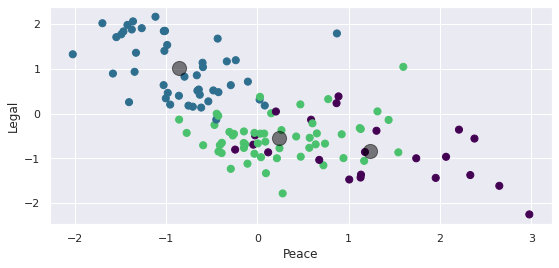

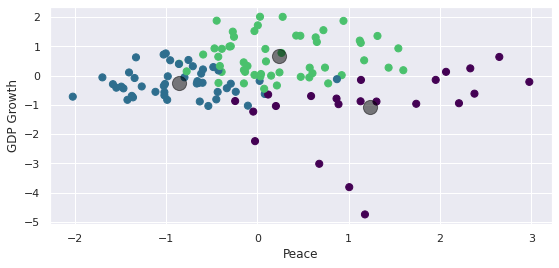

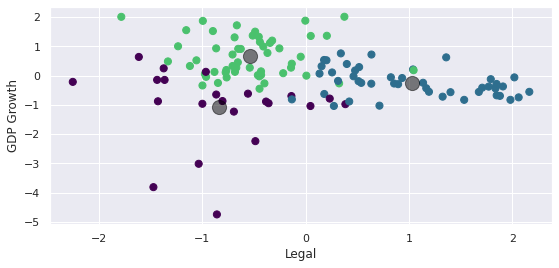

In [ ]:
figs = [(0, 1), (0, 2), (1, 2)]
labels = ['Peace', 'Legal', 'GDP Growth']
cmap = cm.viridis
norm = clrs.Normalize(vmin=0.,vmax=y_predict.max() + 0.8)
centers = kmeans.cluster_centers_
X_scaled = pd.DataFrame(X_scaled)

for i in range(3):
    fig = plt.figure(i)
    plt.scatter(X_scaled.iloc[:,figs[i][0]], X_scaled.iloc[:,figs[i][1]], c=cmap(norm(y_predict)), s=50)
    plt.scatter(centers[:, figs[i][0]], centers[:, figs[i][1]], c='black', s=200, alpha=0.5)
    plt.xlabel(labels[figs[i][0]])
    plt.ylabel(labels[figs[i][1]])

plt.show()

The feature values of the countries in high risk clusters are visualized in the below plot,

In [ ]:
cluster2 = raw_copy[raw_copy['Cluster'] == 2]
three_feature_cluster_countries = cluster2.Country
fig2 = px.scatter_3d(cluster2, x="Corruption", y="Legal", z="GDP Growth", color="Country",
                 size="Peace")
fig2.update_layout(title="High Risk Cluster with Default n_init Hyperparameter")
fig2.show()

And, the countries in the high risk cluster with 4 features are below,

In [ ]:
raw_copy.columns

Index(['Country', 'Abbrev', 'Corruption', 'Peace', 'Legal', 'GDP Growth',
       'Cluster'],
      dtype='object')

In [ ]:
raw_copy = raw_copy.drop(["Cluster"],axis=1)
raw_copy['Cluster'] = clusters_with_default_n_init_value
cluster2 = raw_copy[raw_copy['Cluster'] == 2]
four_feature_cluster_countries = cluster2.Country
fig2 = px.scatter_3d(cluster2, x="Corruption", y="Legal", z="GDP Growth", color="Country",
                 size="Peace")
fig2.update_layout(title="High Risk Cluster with Default n_init Hyperparameter")
fig2.show()

The sci-kit estimators created with respectively three and four features has similar high risk clusters' entities. Let's compare the countries in the high risk clusters of the both K-Means Clustering estimators.

In [ ]:
difference = list(set(four_feature_cluster_countries) - set(three_feature_cluster_countries))
print("The countries which are not in both clusters are:",difference)

The countries which are not in both clusters are: ['Turkey', 'Iran', 'Russia', 'Paraguay', 'Pakistan', 'Nigeria', 'Mexico', 'Yemen', 'Brazil', 'Trinidad and Tobago', 'Ecuador', 'Zimbabwe', 'Saudi Arabia', 'Burundi', 'Lebanon', 'Nicaragua', 'South Africa', 'Argentina', 'Ukraine', 'Chad', 'Liberia', 'Democratic Republic of Congo']


So, it seems that both clusters which have different feature count in the estimators has the very same countries in them. The changes in this hyperparameter, **n_cluster**, has no impact on the changing of the high risk cluster. 